In [1]:
import os

import torch
import xarray as xr
import numpy as np

/perm/syma/conda-envs/shared/gnn-pyg-2.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
input_dir = "/ec/res4/hpcperm/syma/gnn/"
graph_mappings = torch.load(os.path.join(input_dir, "graph_mappings_normed_edge_attrs.pt"))

In [4]:
graph_mappings

HeteroData(
  (h3, to, h3)={
    edge_index=[2, 41174],
    edge_attr=[41174, 1]
  },
  (era, to, era)={
    edge_index=[2, 586440],
    edge_attr=[586440, 1]
  },
  (h3, to, era)={
    edge_index=[2, 195480],
    edge_attr=[195480, 1]
  },
  (era, to, h3)={
    edge_index=[2, 70584],
    edge_attr=[70584, 1]
  }
)

In [5]:
with xr.open_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/pl_2004.nc", chunks={"time": 1}) as era:
    era = era.assign_coords({"longitude": (((era.longitude + 180) % 360) - 180)})
    era = era.sortby("longitude").sortby("latitude")
    elats, elons = np.meshgrid(era.latitude.values, era.longitude.values)
    ecoords = np.array([elats, elons]).T.reshape((-1, 2))
    print(ecoords.shape)
    ecoords_sp = np.deg2rad(ecoords)

(65160, 2)


In [6]:
781920 / 65160

12.0

In [7]:
ecoords.shape, ecoords_sp.shape

((65160, 2), (65160, 2))

In [8]:
import h3

resolution = 2
base_h3_grid = sorted(list(h3.uncompact(h3.get_res0_indexes(), resolution)))

hcoords = []
for h3_point in base_h3_grid:
    hcoords.append(h3.h3_to_geo(h3_point))

hcoords = np.array(hcoords)
hcoords = np.sort(hcoords, axis=0)
hcoords.shape

(5882, 2)

In [9]:
hcoords_sp = np.deg2rad(hcoords)
hcoords_sp.min(), hcoords_sp.max()

(-3.1411522715671913, 3.140526772388204)

In [10]:
hcoords[:5, :]

array([[ -89.24152403, -179.97476797],
       [ -87.66800581, -179.94176051],
       [ -87.65342402, -179.90556962],
       [ -86.91162808, -179.78574109],
       [ -86.88988502, -179.75553828]])

In [11]:
ecoords[:5, :]

array([[ -90., -180.],
       [ -90., -179.],
       [ -90., -178.],
       [ -90., -177.],
       [ -90., -176.]], dtype=float32)

In [12]:
HPTS = [3410, 3511, 3600, 3641, 3655, 3700, 3777, 3909]

h3_lat, h3_lon = hcoords[HPTS, 0], hcoords[HPTS, 1]

In [13]:
hcoords[HPTS, :]

array([[ 8.98298166, 28.54528035],
       [10.95554259, 34.5907602 ],
       [12.74361393, 40.31996024],
       [13.52661671, 42.15058295],
       [13.76645222, 43.45280014],
       [14.79878658, 45.83978925],
       [16.2782673 , 50.36006364],
       [19.0753783 , 57.80380324]])

In [14]:
# figure out the ERA5 neighbors of all these points
from sklearn.neighbors import NearestNeighbors

NUM_H3_NEIGHBORS = 7
NUM_ERA_NEIGHBORS = 9

eneigh = NearestNeighbors(
    n_neighbors=NUM_ERA_NEIGHBORS,
    metric="haversine",
    n_jobs=4
)
eneigh.fit(ecoords_sp)

NearestNeighbors(metric='haversine', n_jobs=4, n_neighbors=9)

In [15]:
NUM_H3_TO_ERA_NEIGHBORS = 3
NUM_ERA_TO_H3_NEIGHBORS = 12

era_to_h3_adjmat = eneigh.kneighbors_graph(
    hcoords_sp[HPTS],
    n_neighbors=NUM_ERA_TO_H3_NEIGHBORS,
    mode="distance",
).tocoo()
era_to_h3_adjmat

<8x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 96 stored elements in COOrdinate format>

In [16]:
era_to_h3_adjmat.data.shape

(96,)

In [17]:
era_to_h3_edge_index = np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)
EPTS = era_to_h3_edge_index.shape[-1]

In [18]:
era_to_h3_edge_index

array([[35849, 35848, 35489, 36209, 35488, 36208, 35850, 35847, 35490,
        36210, 35487, 36207, 36575, 36574, 36215, 36214, 36935, 36934,
        36576, 36573, 36216, 36936, 36213, 36933, 37300, 37301, 36940,
        36941, 37660, 37299, 37661, 36939, 37302, 36580, 37659, 36942,
        37662, 37302, 37663, 37303, 37661, 37301, 38022, 36942, 38023,
        36943, 38021, 37664, 37663, 37664, 37303, 37304, 38023, 38024,
        37662, 37665, 37302, 37305, 36943, 36944, 38026, 37666, 38025,
        38027, 37665, 38386, 37667, 38385, 38387, 38024, 37306, 37664,
        38390, 38391, 38750, 38751, 38030, 38389, 38031, 38749, 38392,
        38752, 39110, 39111, 39478, 39477, 39838, 39118, 39479, 39837,
        39117, 39839, 39119, 39476, 40198, 39836],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     2,     2,     2,
            2,     2,     

In [19]:
era_to_h3_edge_index[0, :]

array([35849, 35848, 35489, 36209, 35488, 36208, 35850, 35847, 35490,
       36210, 35487, 36207, 36575, 36574, 36215, 36214, 36935, 36934,
       36576, 36573, 36216, 36936, 36213, 36933, 37300, 37301, 36940,
       36941, 37660, 37299, 37661, 36939, 37302, 36580, 37659, 36942,
       37662, 37302, 37663, 37303, 37661, 37301, 38022, 36942, 38023,
       36943, 38021, 37664, 37663, 37664, 37303, 37304, 38023, 38024,
       37662, 37665, 37302, 37305, 36943, 36944, 38026, 37666, 38025,
       38027, 37665, 38386, 37667, 38385, 38387, 38024, 37306, 37664,
       38390, 38391, 38750, 38751, 38030, 38389, 38031, 38749, 38392,
       38752, 39110, 39111, 39478, 39477, 39838, 39118, 39479, 39837,
       39117, 39839, 39119, 39476, 40198, 39836])

In [20]:
era5_lat, era5_lon = ecoords[era_to_h3_edge_index[0, :], 0], ecoords[era_to_h3_edge_index[0, :], 1]

In [21]:
era_to_h3_edge_attr = graph_mappings[("era", "to", "h3")].edge_attr.numpy()
era_to_h3_edge_attr.shape

(70584, 1)

In [22]:
era_to_h3_edge_index.shape

(2, 96)

In [23]:
era_to_h3_adjmat.data

array([0.00784445, 0.00940468, 0.01886659, 0.01939961, 0.01956866,
       0.02007935, 0.02507941, 0.02664046, 0.03041216, 0.03069464,
       0.03171517, 0.03197916, 0.00705468, 0.01015175, 0.01809593,
       0.01951736, 0.01952689, 0.02084234, 0.02415826, 0.02726695,
       0.02937806, 0.03022068, 0.03199157, 0.03275052, 0.00704707,
       0.0124058 , 0.01407817, 0.01740242, 0.02259107, 0.02290012,
       0.02478248, 0.02597694, 0.02893345, 0.03091856, 0.03135541,
       0.03144441, 0.00864745, 0.00954053, 0.01660133, 0.01710822,
       0.0211825 , 0.02159891, 0.02584123, 0.02676748, 0.02945692,
       0.03031453, 0.03224968, 0.03242181, 0.00868762, 0.01012792,
       0.01542905, 0.01628711, 0.02284988, 0.02343282, 0.02495055,
       0.02652983, 0.02806105, 0.02947997, 0.03177827, 0.03220531,
       0.00443112, 0.01420208, 0.01459313, 0.01988128, 0.01989734,
       0.02113773, 0.02406326, 0.02528257, 0.02864693, 0.03122877,
       0.03151186, 0.03408303, 0.00774778, 0.01177684, 0.01396

In [24]:
era_to_h3_edge_index.shape[-1]

96

0 0 0.00784444899156631
0 1 0.009404676378190065
0 2 0.01886658903623871
0 3 0.019399607986371324
0 4 0.019568657501517792
0 5 0.020079349226537136
0 6 0.02507940535340903
0 7 0.026640460542458236
0 8 0.030412159670802432
0 9 0.030694635617033398
0 10 0.031715168174606644
0 11 0.03197916432534186
1 12 0.00705467842910684
1 13 0.010151753891341231
1 14 0.018095929307545645
1 15 0.019517361906277664
1 16 0.01952689304125917
1 17 0.02084234171865308
1 18 0.024158256395220037
1 19 0.027266947604024237
1 20 0.02937805518261436
1 21 0.030220677941165088
1 22 0.031991571736819754
1 23 0.03275051946686514
2 24 0.007047073790383187
2 25 0.012405800252343184
2 26 0.014078169648125008
2 27 0.0174024200571696
2 28 0.02259107004229091
2 29 0.02290012240355095
2 30 0.024782476714409463
2 31 0.025976944867023982
2 32 0.028933450066091045
2 33 0.03091856293278913
2 34 0.03135541162454181
2 35 0.03144440984884073
3 36 0.008647452693533522
3 37 0.009540528208308979
3 38 0.016601332657937177
3 39 0.01710

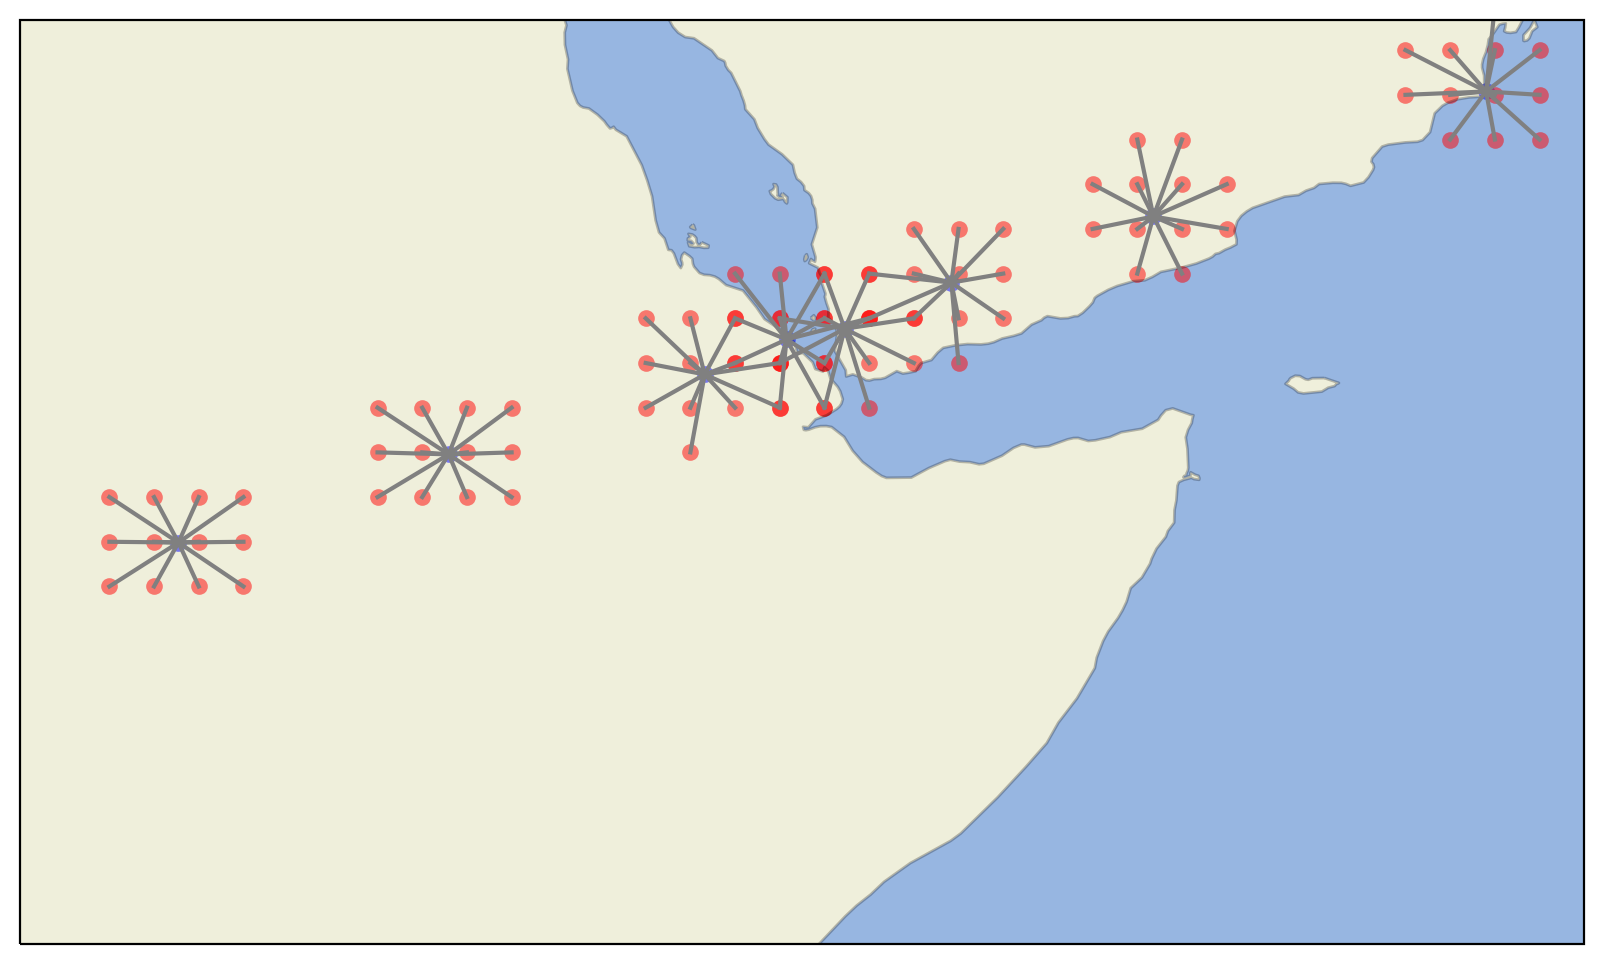

In [25]:
fig = plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.25)
# ax.gridlines(color="black", linestyle="--", linewidth=0.25)
ax.set_global()
ax.set_extent([25, 60, 0, 20]) # horn of Africa
ax.add_feature(cf.LAND)
ax.add_feature(cf.OCEAN)

h3_cvals = -1 * np.ones(len(HPTS))
era5_cvals = np.ones(EPTS)

cmap = "bwr"
plt.scatter(h3_lon, h3_lat, transform=ccrs.PlateCarree(),
            label=None, linewidth=0, alpha=0.5, color="blue")
plt.scatter(era5_lon, era5_lat, transform=ccrs.PlateCarree(),
            label=None,  linewidth=0, alpha=0.5, color="red")
plt.xlabel('longitude')
plt.ylabel('latitude')

for i in range(len(HPTS)):
    for j in range(EPTS):
        if era_to_h3_edge_index[1, j] == i:
            plt.plot([h3_lon[i], era5_lon[j]], [h3_lat[i], era5_lat[j]], color='gray', linestyle='-', transform=ccrs.PlateCarree())
            print(i, j, era_to_h3_adjmat.data[j])

In [26]:
import einops
result = einops.repeat(torch.from_numpy(era_to_h3_edge_attr), "e f -> (repeat e) f", repeat=4)
result.shape

torch.Size([282336, 1])

In [27]:
era_to_h3_edge_index = graph_mappings[("era", "to", "h3")].edge_index.numpy()
era_to_h3_edge_index[:, :100]

array([[ 360,  361,  719,  362,  718,  363,  717,  364,  716,  365,  715,
         366,  720,  721, 1079,  722, 1078,  723, 1077,  724, 1076,  725,
        1075,  726,  720,  721, 1079,  722, 1078,  723, 1077,  724, 1076,
         725, 1075,  726, 1080, 1081, 1439, 1082, 1438, 1083, 1437, 1084,
        1436, 1085, 1435, 1086, 1080, 1081, 1439, 1082, 1438, 1083, 1437,
        1084, 1436, 1085, 1435, 1086, 1440, 1441, 1799, 1442, 1798, 1443,
        1797, 1444, 1796, 1445, 1080, 1081, 1440, 1441, 1799, 1442, 1798,
        1443, 1797, 1444, 1796, 1445, 1080, 1081, 1440, 1441, 1799, 1442,
        1798, 1443, 1797, 1444, 1796, 1445, 1795, 1446, 1800, 1801, 2159,
        1802],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    

In [28]:
era_to_h3_edge_index.min(), era_to_h3_edge_index.max()

(0, 64799)

In [29]:
h3_to_era_edge_index = graph_mappings[("h3", "to", "era")].edge_index.numpy()
h3_to_era_edge_index.min(), h3_to_era_edge_index.max()

(0, 65159)

In [30]:
h3_to_era_edge_index[1, :].max()

65159